# Uso del módulo fordward

En el módulo *forward* se implementan algunas formas de resolución del problema directo de imágenes por microondas de un arreglo circular de antenas. Para el caso analítico solo se considera el caso en que el dispersor es un cilindro centrado. En los casos del método de diferencias finitas (FDTD), elementos finitos (FEM), y el método de los momentos (MoM) se pueden generar geometrías más complejas.

- FDTD está implementado en el software [meep](https://meep.readthedocs.io/en/latest/).

- FEM está implementado en el software [FEniCS](https://fenicsproject.org/)***(IMPLEMENTAR).

- MoM está implementado completo basado en [1]***(IMPLEMENTAR).

Libros y publicaciones:

[1] Xudong Chen, Computational Methods for Electromagnetic Inverse Scattering

[2] Matteo Pastorino, Microwave Imaging


Módulo Python: forward

Author: Ramiro Irastorza 

Email: rirastorza@iflysib.unlp.edu.ar


## Módulo forward **COMPLETAR

Si se ejecuta solo con la instrucción:

> python3 forward.py

Se simulará un modelo específico, con un cilindro centrado con características particulares y se desarrollarán las 16 simulaciones (una con cada transmisor emitiendo). 

A continuación se comentan varios ejemplos de simulación.

### Conversión de parámetros $S_{12}$ a campo eléctrico $E_{z}$ 

El coeficiente de transmisión entre antena transmisora (tx) y receptora (tr) se denomina parámetro S12. Esto se puede extraer de las simulaciones utilizando diferencias finitas en meep. Para esto, se utilizan algunas ideas de los siguientes enlaces: [enlace 1](https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics/#mie-scattering-of-a-lossless-dielectric-sphere), [enlace 2](https://meep.readthedocs.io/en/latest/Python_Tutorials/Near_to_Far_Field_Spectra/) y las bases teóricas de este otro [enlace](https://meep.readthedocs.io/en/latest/Introduction/#transmittancereflectance-spectra). La idea es calcular para una frecuencia dada la integral del vector de Poynting en la dirección normal a una superficie de interés (que encierra el transmisor y el receptor). Luego, se el cociente entre ambos flujos.

Primero se importa todo lo necesario:

In [1]:
from forward import *
import time as tm
import os
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt

Iniciamos el contador para estimar cuanto tarda la simulación del modelo.

In [5]:
start_time = tm.strftime('%H:%M:%S')

Se define la frecuencia, el tamaño de la caja de simulación 25 cm x 25 cm, donde está el arreglo de n antenas (en el ejemplo 4 antenas). Se crean los objetos TRANSMISOR_parameters y ACOPLANTE_parameters y se les asignan las propiedades. Estos objetos contienen información del arreglo de antenas y del fluido de acoplamiento, respectivamente. El acoplante, en este ejemplo, es agua con sal cuyo modelo dieléctrico es un Debye (una frecuencia de relajación) con conductividad iónica.

frecuencia de medición (GHz):  1.1
permitividad imaginaria:  -11.802746734699134


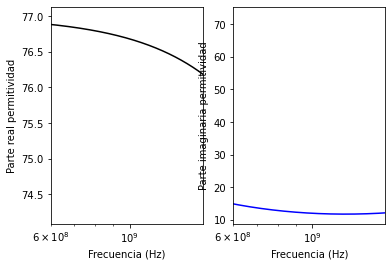

In [6]:
f = 1.1e9
print('frecuencia de medición (GHz): ',f/1e9)
sx = 0.25
sy = 0.25
box = [sx,sy]

TRANSMISOR_parameters = TRANSMISOR_parameters()
TRANSMISOR_parameters.f = f
TRANSMISOR_parameters.amp = 7500.
TRANSMISOR_parameters.rhoS = 0.075
TRANSMISOR_parameters.S = 4.

#Debye
frel = 15e9
sigmadc = 400e-3
frec = N.linspace(100e6,3e9,1000)#para dibujar
epsc = 4.8+(77.0-4.8)/(1+1j*frec/frel)+sigmadc/(1j*eps0*2*pi*frec)#para dibujar

fig2 = plt.figure(1)
ax1 = fig2.add_subplot(121)
ax1.semilogx(frec,epsc.real,'-k')
ax1.set_xlim([0.6e9, 1.6e9])
ax1.set_ylabel('Parte real permitividad')
ax1.set_xlabel('Frecuencia (Hz)')
ax2 = fig2.add_subplot(122)
#conductividad = -epsc.imag*(eps0*2*pi*frec)
ax2.semilogx(frec,-epsc.imag,'-b')
ax2.set_xlim([0.6e9, 1.6e9])
ax2.set_ylabel('Parte imaginaria permitividad')
ax2.set_xlabel('Frecuencia (Hz)')

#Definición de Debye para simular:
epsc = 4.8+(77.0-4.8)/(1+1j*TRANSMISOR_parameters.f/frel)+sigmadc/(1j*eps0*2*pi*TRANSMISOR_parameters.f)
ACOPLANTE_parameters = ACOPLANTE_parameters()
ACOPLANTE_parameters.f = TRANSMISOR_parameters.f
ACOPLANTE_parameters.epsr = epsc.real 
ACOPLANTE_parameters.sigma = -epsc.imag*(eps0*2*pi*TRANSMISOR_parameters.f)
print('permitividad imaginaria: ',epsc.imag)
plt.show()

Luego se define el cilindro dispersor pasando los parámetros al objeto SCATTERER_parameters. El cilindro está centrado en (0,0) y es de teflon (permitividad relativa 2.1 y conductividad nula). Aquí también lo dibujamos, junto con el arreglo de antenas.

Xc: 0.0 Yc: 0.0 r: 0.0125


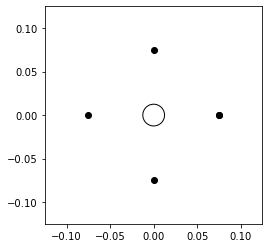

Permitividad medio: 76.61380133504267
Conductividad medio: 0.722277974484009
Permitividad del cilindro: 2.1
Conductividad del cilindro: 0.0


In [7]:
#Coordenadas antenas
angulo = N.linspace(0.0, 2.0*pi, 5)
xantenas = (TRANSMISOR_parameters.rhoS)*N.cos(angulo)
yantenas = (TRANSMISOR_parameters.rhoS)*N.sin(angulo)

#Generación de modelos
r = 25.0e-3/2.0
Xc = 0.0
Yc = 0.0

print('Xc:', Xc,'Yc:', Yc,'r:',r)

#Dibujo la geometría generada
cilindro = plt.Circle((Xc,Yc),r,fill = False)

figure, axes = plt.subplots()
plt.xlim(-0.25/2, 0.25/2)
plt.ylim(-0.25/2 , 0.25/2)
axes.set_aspect(1)
axes.add_artist(cilindro)
axes.plot(xantenas,yantenas,'ok')
plt.show()

#Comienzo de simulación
cilindro1 = SCATTERER_parameters()
cilindro1.epsr = 2.1 #permitividad relativa. Entre [10.0, 80.0]
cilindro1.sigma = 0.0
cilindro1.f = TRANSMISOR_parameters.f #frecuencia 1 GHz (por defecto).
cilindro1.radio = r
cilindro1.xc = Xc
cilindro1.yc = Yc

print('Permitividad medio:',ACOPLANTE_parameters.epsr)
print('Conductividad medio:',ACOPLANTE_parameters.sigma)

print('Permitividad del cilindro:',cilindro1.epsr)
print('Conductividad del cilindro:',cilindro1.sigma)


Transmisor:
----------------------
-15.0 1.8369701987210296e-15
-14.8 1.8369701987210296e-15
----------------------
Receptor:
----------------------
15.0 0.0
14.8 0.0
----------------------
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 2D dimensions.
Computational cell is 50 x 50 x 0 with resolution 5
     cylinder, center = (0,0,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (76.6138,76.6138,76.6138)
     cylinder, center = (15,0,0)
          radius 0.1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (-1e+20,-1e+20,-1e+20)
time for set_epsilon = 0.049778 s
time for set_conductivity = 0.00396109 s
time for set_conductivity = 0.00464916 s
time for set_conductivity = 0.00442314 s
-----------


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Meep progress: 864.1/1500.0 = 57.6% done in 4.0s, 2.9s to go
on time step 8668 (time=866.8), 0.000461482 s/step
run 0 finished at t = 1500.0 (15000 timesteps)
Transmisor:
----------------------
-15.0 1.8369701987210296e-15
-14.8 1.8369701987210296e-15
----------------------
Receptor:
----------------------
15.0 0.0
14.8 0.0
----------------------
-----------
Initializing structure...
time for choose_chunkdivision = 0.000183105 s
Working in 2D dimensions.
Computational cell is 50 x 50 x 0 with resolution 5
     cylinder, center = (0,0,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     cylinder, center = (15,0,0)
          radius 0.1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (-1e+20,-1e+20,-1e+20)
time for set_epsilon = 0.0543499 s
time for set_conductivity = 0.00384116 s
time for set_conductivity = 0.00342607 s
time for set_conductivity = 0.00366306 s
-----------


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Meep progress: 1028.6000000000001/1500.0 = 68.6% done in 4.0s, 1.8s to go
on time step 10303 (time=1030.3), 0.000388263 s/step
run 0 finished at t = 1500.0 (15000 timesteps)
S12inc:  [-65.74552338]
S12cil:  [-77.23195055]


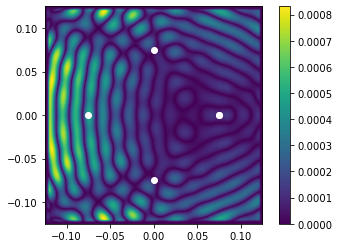

start time:  15:09:10
end time:    15:09:45


In [8]:
resolucion = 5
#n = resolucion*sx/a
#Tx = N.arange(4)
#Tr = N.arange(4)
#EzTr = N.zeros((4,4))

tx = 2
tr = 0
ez_data,eps_data,freqs,near_flux_transmisor,near_flux_receptor = RunMeep_flux(cilindro1,ACOPLANTE_parameters,TRANSMISOR_parameters, tx,tr, box,RES = 5,calibration = True)
ez_data_cil,eps_data_cil,freqs,near_flux_transmisor_cil,near_flux_receptor_cil = RunMeep_flux(cilindro1,ACOPLANTE_parameters,TRANSMISOR_parameters, tx,tr, box,RES = 5,calibration = False)

#print(freqs[0])
#print(near_flux_transmisor_cil[0])
#print(near_flux_receptor_cil[0])

frecuencia = (c/a)*N.asarray(freqs)
S12inc = 10*np.log10(abs(N.asarray(near_flux_receptor))/abs(N.asarray(near_flux_transmisor)))
#print('frecuencia: ',frecuencia/1e9)
print('S12inc: ',S12inc)
S12cil = 10*np.log10(abs(N.asarray(near_flux_receptor_cil))/abs(N.asarray(near_flux_transmisor_cil)))
print('S12cil: ',S12cil)

#xS = (0.15/2)*N.cos(tx*2*pi/4.) #Coordenada x antena emisora
#yS = (0.15/2)*N.sin(tx*2*pi/4.)

plt.figure()
extent2=[-0.25/2,0.25/2,-0.25/2,0.25/2]
plt.imshow(abs(ez_data).transpose(),extent = extent2)#cmap = 'binary')
plt.plot(xantenas,yantenas,'ow')
plt.colorbar()

plt.show()


print('start time: ', start_time)
print('end time:   ', tm.strftime('%H:%M:%S'))

Como resultado se tiene que: $S_{12}$ sin dispersor es **-64 dB** y $S_{12}$ con cilindro dispersor es **-75 dB** para los receptores opuestos.

Si quisiera saber los receptores más cercanos debo correr la siguiente simulación:

In [9]:
tx = 0
tr = 3
ez_data,eps_data,freqs,near_flux_transmisor,near_flux_receptor = RunMeep_flux(cilindro1,ACOPLANTE_parameters,TRANSMISOR_parameters, tx,tr, box,RES = 5,calibration = True)
ez_data_cil,eps_data_cil,freqs,near_flux_transmisor_cil,near_flux_receptor_cil = RunMeep_flux(cilindro1,ACOPLANTE_parameters,TRANSMISOR_parameters, tx,tr, box,RES = 5,calibration = False)

S12inc = 10*np.log10(abs(N.asarray(near_flux_receptor))/abs(N.asarray(near_flux_transmisor)))
print('S12inc: ',S12inc)
S12cil = 10*np.log10(abs(N.asarray(near_flux_receptor_cil))/abs(N.asarray(near_flux_transmisor_cil)))
print('S12cil: ',S12cil)

Transmisor:
----------------------
15.0 0.0
15.2 0.0
----------------------
Receptor:
----------------------
-2.7554552980815444e-15 -15.0
-0.20000000000000276 -15.0
----------------------
-----------
Initializing structure...
time for choose_chunkdivision = 0.000332117 s
Working in 2D dimensions.
Computational cell is 50 x 50 x 0 with resolution 5
     cylinder, center = (0,0,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (76.6138,76.6138,76.6138)
     cylinder, center = (-2.75546e-15,-15,0)
          radius 0.1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (-1e+20,-1e+20,-1e+20)
time for set_epsilon = 0.056042 s
time for set_conductivity = 0.00351501 s
time for set_conductivity = 0.00364399 s
time for set_conductivity = 0.00390387 s
-----------


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Meep progress: 1001.5/1500.0 = 66.8% done in 4.0s, 2.0s to go
on time step 10032 (time=1003.2), 0.000398734 s/step
run 0 finished at t = 1500.0 (15000 timesteps)
Transmisor:
----------------------
15.0 0.0
15.2 0.0
----------------------
Receptor:
----------------------
-2.7554552980815444e-15 -15.0
-0.20000000000000276 -15.0
----------------------
-----------
Initializing structure...
time for choose_chunkdivision = 0.00037694 s
Working in 2D dimensions.
Computational cell is 50 x 50 x 0 with resolution 5
     cylinder, center = (0,0,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     cylinder, center = (-2.75546e-15,-15,0)
          radius 0.1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (-1e+20,-1e+20,-1e+20)
time for set_epsilon = 0.053978 s
time for set_conductivity = 0.00290298 s
time for set_conductivity = 0.00351596 s
time for set_conductivity = 0.00439882 s
-----------


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Meep progress: 1006.2/1500.0 = 67.1% done in 4.0s, 2.0s to go
on time step 10092 (time=1009.2), 0.000396409 s/step
run 0 finished at t = 1500.0 (15000 timesteps)
S12inc:  [-58.19486679]
S12cil:  [-58.82093644]


Lo que da como resultado se tiene que: $S_{12}$ sin dispersor es **-57.14 dB** y $S_{12}$ con cilindro dispersor es **-57.8 dB** para los receptores opuestos.

## Conclusión

Esta simulación se corre en el dominio de tiempo y se transforma con Fourier (DFT) con las herramientas de meep. En este caso el tiempo que es necesario correr es *nt = 1500*, se probó con más y el resultado fue prácticamente el mismo. Como el receptor es metálico (antena), y ésta es móvil entonces se debe correr para cada receptor una simulación, esto es porque estamos simulando el modelo experimental. A continuación se comparan cono medidas experimentales.

In [2]:
centrado = 'Med_pos_1_pos_2_prueba1.txt'#Cilindro de teflon antenas 1 y 2
datos = np.loadtxt(centrado,skiprows=1)
print('Antenas 1 y 2')
print('f: ',datos[149,0],' MHz')
print('S12: ',datos[149,1])


Antenas 1 y 2
f:  1100.0  MHz
S12:  -48.185421


In [3]:
centrado = 'Med_pos_1_pos_3_prueba1.txt'#Cilindro de teflon antenas 1 y 2
datos = np.loadtxt(centrado,skiprows=1)
print('Antenas 1 y 3')
print('f: ',datos[149,0],' MHz')
print('S12: ',datos[149,1])

Antenas 1 y 3
f:  1100.0  MHz
S12:  -49.941276


In [4]:
centrado = 'Med_pos_1_pos_4_prueba1.txt'#Cilindro de teflon antenas 1 y 2
datos = np.loadtxt(centrado,skiprows=1)
print('Antenas 1 y 4')
print('f: ',datos[149,0],' MHz')
print('S12: ',datos[149,1])


Antenas 1 y 4
f:  1100.0  MHz
S12:  -52.11972
